### Additional Resources:
1. Exploratory Data Analysis:

https://www.youtube.com/watch?v=xi0vhXFPegw&t=1925s

2. Machine Learning:

https://www.youtube.com/playlist?list=PLTKMiZHVd_2KyGirGEvKlniaWeLOHhUF3


https://www.ibm.com/think/machine-learning#605511093


https://alan-turing-institute.github.io/Intro-to-transparent-ML-course/index.html


https://junaidsqazi.medium.com/ (A series)

https://medium.com/data-science/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a (Handling Class Imbalanaces)


Import modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler

Load the loan data into a pandas dataframe

In [ ]:
input_file_path = "/content/drive/MyDrive/Tangible/DataSet17Dec2025.xlsx"
df = pd.read_excel(input_file_path, sheet_name=1)

Only use the latest entry for each customer

In [ ]:
df['AS_ON'] = pd.to_datetime(df['AS_ON'])

# Sort by ID and Date (Ascending), then keep the LAST one (Latest date)
df = df.sort_values(by=['MAPPED_FORACID', 'AS_ON'], ascending=[True, True])
initial_count = len(df)
df = df.drop_duplicates(subset=['MAPPED_FORACID'], keep='last')

print(f"Original Records: {initial_count}")
print(f"Unique Accounts (Latest Month Only): {len(df)}")
df.columns

Original Records: 139776
Unique Accounts (Latest Month Only): 46592


Index(['ACCT_OPN_DATE', 'SCHM_TYPE', 'INTTRATE', 'CUST_DOB', 'MONTHLY_AVG_DEP',
       'FD_AMT', 'MONTHLY_AVG_CR_AMT', 'MONTHLY_AVG_DR_AMT',
       'MONTHLY_NO_OF_TXNS', 'DISTRICT', 'PROVINCE', 'PROFESSION',
       'RISK_RATING', 'DORMANT_STATUS', 'NO_OF_QR_TXNS', 'NO_OF_POS_TXNS',
       'FONELOAN_OS', 'CC_OS', 'MAPPED_FORACID', 'MAPPED_CIF_ID', 'AS_ON'],
      dtype='object')

In [ ]:
numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns
for col in numeric_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(0)
        print(f"Filled NaN in numeric column '{col}' with 0.")

# Handle Missing Categorical Values: Replace NaN with 'Unknown'
for col in categorical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna('Unknown')
        print(f"Filled NaN in categorical column '{col}' with 'Unknown'.")
print(categorical_cols)
# Group all the categories with less than 1% data into a single group
for col in categorical_cols:
    if col in ['CUST_DOB', 'MAPPED_FORACID', 'MAPPED_CIF_ID', 'ACCT_OPN_DATE', 'AS_ON']: continue
    value_counts = df[col].value_counts(normalize=True)
    sparse_categories = value_counts[value_counts < 0.01].index
    if not sparse_categories.empty:
        df[col] = df[col].replace(sparse_categories, 'Other')
        print(f"Grouped sparse categories in '{col}' into 'Other'.")



Filled NaN in numeric column 'MONTHLY_AVG_DEP' with 0.
Filled NaN in numeric column 'FD_AMT' with 0.
Filled NaN in numeric column 'MONTHLY_AVG_CR_AMT' with 0.
Filled NaN in numeric column 'MONTHLY_AVG_DR_AMT' with 0.
Filled NaN in numeric column 'MONTHLY_NO_OF_TXNS' with 0.
Filled NaN in numeric column 'NO_OF_QR_TXNS' with 0.
Filled NaN in numeric column 'NO_OF_POS_TXNS' with 0.
Filled NaN in numeric column 'FONELOAN_OS' with 0.
Filled NaN in numeric column 'CC_OS' with 0.
Filled NaN in categorical column 'DISTRICT' with 'Unknown'.
Filled NaN in categorical column 'PROVINCE' with 'Unknown'.
Filled NaN in categorical column 'PROFESSION' with 'Unknown'.
Filled NaN in categorical column 'RISK_RATING' with 'Unknown'.
Filled NaN in categorical column 'DORMANT_STATUS' with 'Unknown'.
Index(['SCHM_TYPE', 'CUST_DOB', 'DISTRICT', 'PROVINCE', 'PROFESSION',
       'RISK_RATING', 'DORMANT_STATUS', 'MAPPED_FORACID', 'MAPPED_CIF_ID'],
      dtype='object')
Grouped sparse categories in 'DISTRICT' int

In [ ]:
df['loan_active'] = ((df['FONELOAN_OS'] > 0) | (df['CC_OS'] > 0)).astype(int)
print(df['loan_active'].value_counts())

loan_active
0    46197
1      395
Name: count, dtype: int64


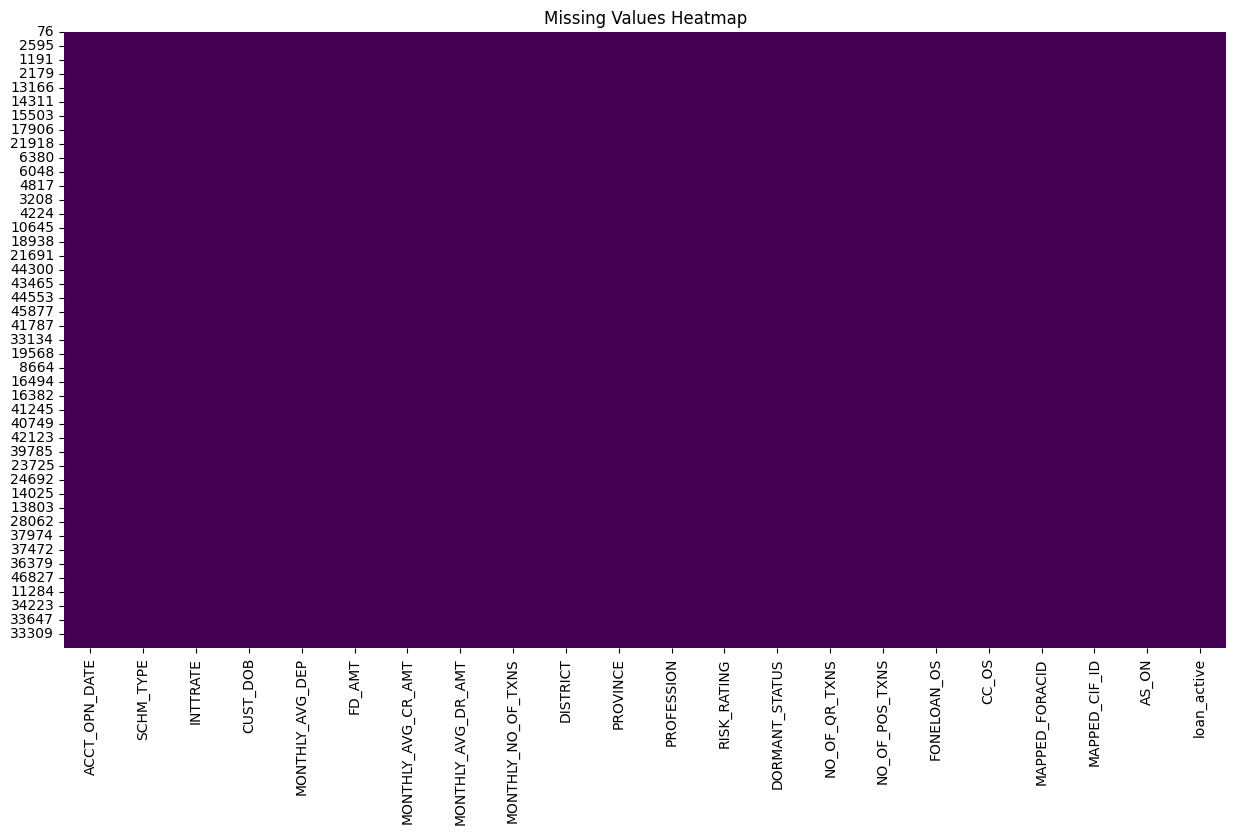

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [ ]:
df.shape
df.columns

Index(['ACCT_OPN_DATE', 'SCHM_TYPE', 'INTTRATE', 'CUST_DOB', 'MONTHLY_AVG_DEP',
       'FD_AMT', 'MONTHLY_AVG_CR_AMT', 'MONTHLY_AVG_DR_AMT',
       'MONTHLY_NO_OF_TXNS', 'DISTRICT', 'PROVINCE', 'PROFESSION',
       'RISK_RATING', 'DORMANT_STATUS', 'NO_OF_QR_TXNS', 'NO_OF_POS_TXNS',
       'FONELOAN_OS', 'CC_OS', 'MAPPED_FORACID', 'MAPPED_CIF_ID', 'AS_ON',
       'foneloan_activate'],
      dtype='object')

## Univariate Analysis

In [ ]:
# Re-identify numerical and categorical columns after adding 'loan_active'
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Exclude identifier columns and date columns if they are still in numerical or categorical lists
exclude_cols = ['MAPPED_FORACID', 'MAPPED_CIF_ID', 'ACCT_OPN_DATE', 'CUST_DOB', 'AS_ON']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

print("Numerical Columns:", numeric_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['INTTRATE', 'MONTHLY_AVG_DEP', 'FD_AMT', 'MONTHLY_AVG_CR_AMT', 'MONTHLY_AVG_DR_AMT', 'MONTHLY_NO_OF_TXNS', 'NO_OF_QR_TXNS', 'NO_OF_POS_TXNS', 'FONELOAN_OS', 'CC_OS', 'loan_active']
Categorical Columns: ['SCHM_TYPE', 'DISTRICT', 'PROVINCE', 'PROFESSION', 'RISK_RATING', 'DORMANT_STATUS']


### Univariate Analysis: Numerical Features

Descriptive Statistics for Numerical Features:


,count,mean,std,min,25%,50%,75%,max
INTTRATE,46592.0,2.777686,0.300166,0.00,2.76,2.760,2.7600,12.13
MONTHLY_AVG_DEP,46592.0,45983.507778,395508.948786,-13.41,55.12,471.465,5146.9925,39464211.24
FD_AMT,46592.0,25689.777301,397884.998312,0.00,0.00,0.000,0.0000,33498198.00
MONTHLY_AVG_CR_AMT,46592.0,9510.253799,115474.084018,0.00,0.00,0.000,0.0000,15800000.00
MONTHLY_AVG_DR_AMT,46592.0,6879.629550,89374.238625,0.00,0.00,0.000,250.0000,7500002.00
MONTHLY_NO_OF_TXNS,46592.0,4.111393,14.277348,0.00,0.00,0.000,1.0000,675.00
NO_OF_QR_TXNS,46592.0,0.744720,3.678483,0.00,0.00,0.000,0.0000,106.00
NO_OF_POS_TXNS,46592.0,0.011569,0.276840,0.00,0.00,0.000,0.0000,19.00
FONELOAN_OS,46592.0,354.469308,7011.211063,0.00,0.00,0.000,0.0000,500000.00
CC_OS,46592.0,75.754040,2560.281206,-31199.29,0.00,0.000,0.0000,259935.42


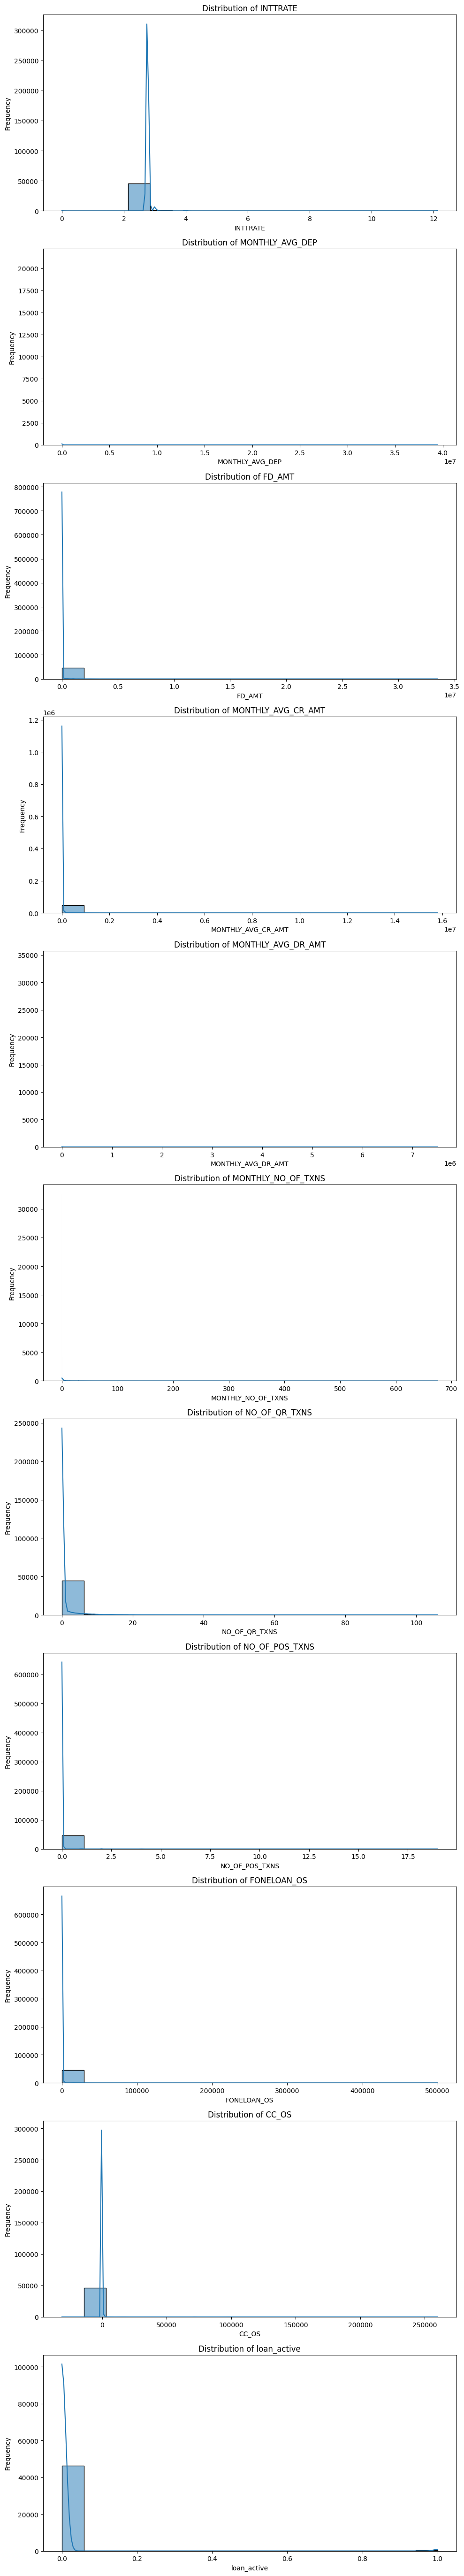

In [ ]:
print("Descriptive Statistics for Numerical Features:")
display(df[numeric_cols].describe().T)

# Plot histograms for numerical features
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 5 * len(numeric_cols)))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Univariate Analysis: Categorical Features

Value Counts for Categorical Features:

--- SCHM_TYPE ---


,proportion
SCHM_TYPE,
SBA,1.0


/tmp/ipython-input-1046606977.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10], palette='viridis')


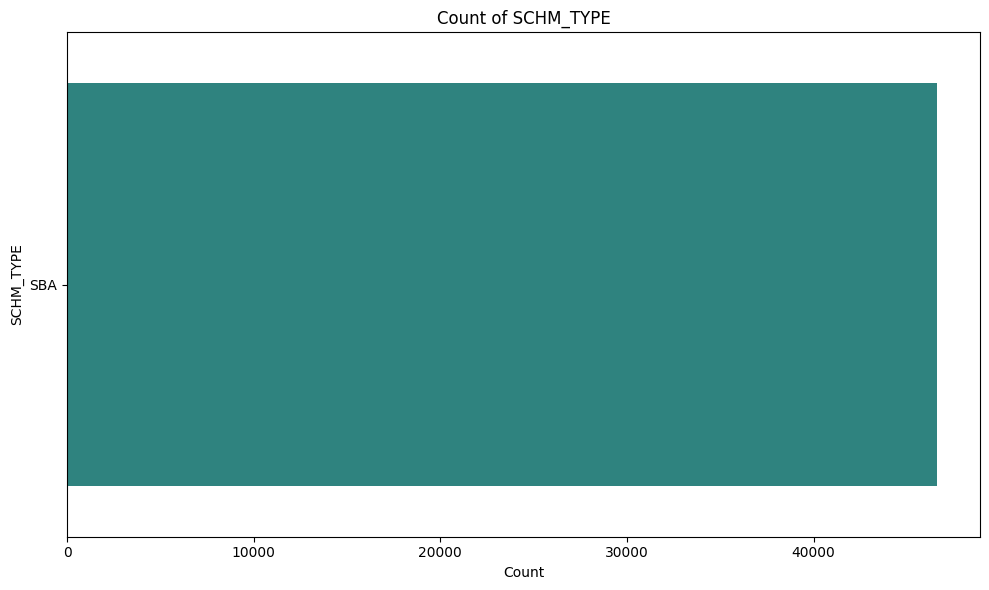


--- DISTRICT ---


,proportion
DISTRICT,
SURKHET,0.161294
KAILALI,0.143651
Other,0.141204
CHITWAN,0.119570
RUPANDEHI,0.097957
Unknown,0.047712
FOR UPLOAD,0.042153
GULMI,0.042024
PALPA,0.035156


/tmp/ipython-input-1046606977.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10], palette='viridis')


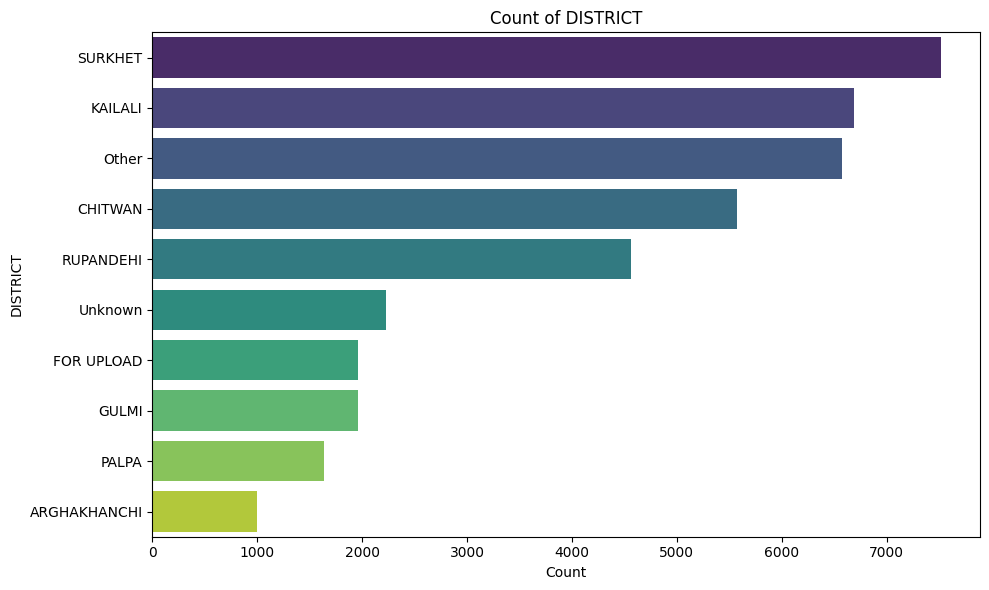


--- PROVINCE ---


,proportion
PROVINCE,
PROVINCE 5,0.251674
PROVINCE 6,0.233173
PROVINCE 7,0.174644
PROVINCE 3,0.142213
PROVINCE 4,0.091217
Unknown,0.047454
PROVINCE 2,0.035027
MIGRA,0.013157
Other,0.011440


/tmp/ipython-input-1046606977.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10], palette='viridis')


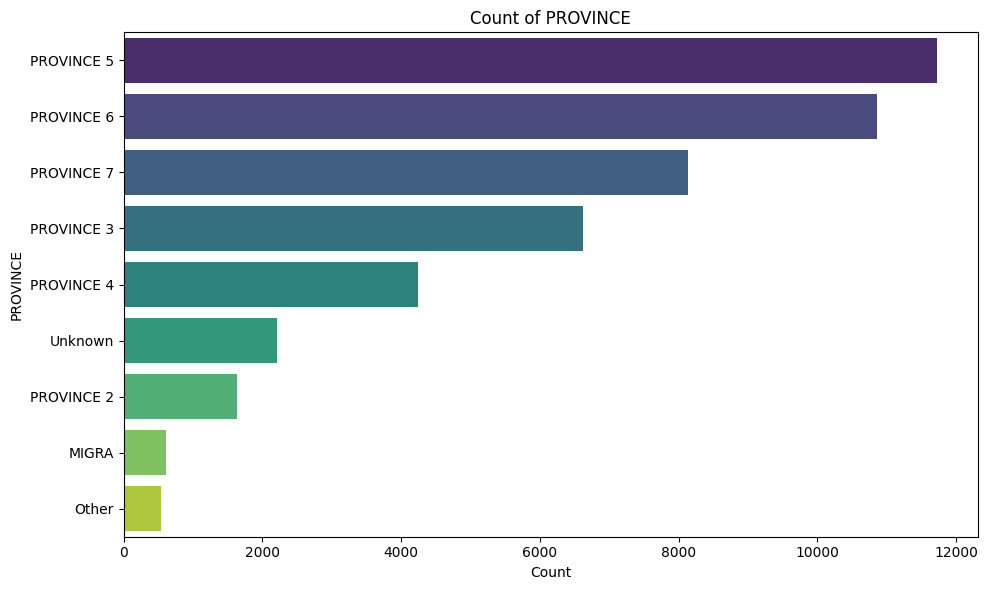


--- PROFESSION ---


,proportion
PROFESSION,
OTHERS,0.177176
Service,0.112594
BUSINESSMAN,0.100532
HOUSEWIFE,0.100253
Other,0.096755
Unknown,0.073360
STUDENT,0.065483
AGRICULTURAL PROFESSION,0.061878
Student,0.054344


/tmp/ipython-input-1046606977.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10], palette='viridis')


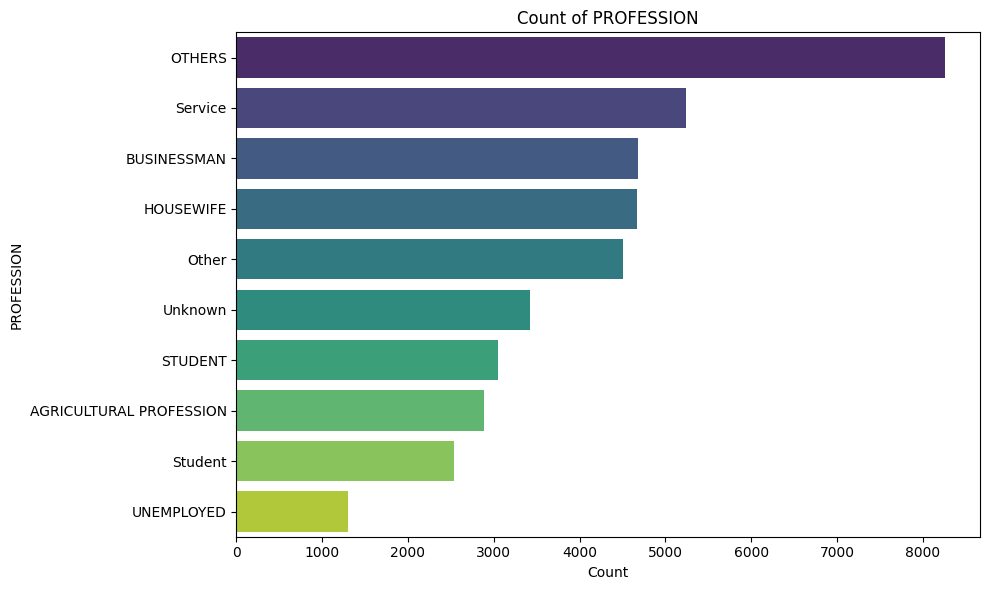


--- RISK_RATING ---


,proportion
RISK_RATING,
LOW,0.932435
MED,0.064367
Other,0.003198


/tmp/ipython-input-1046606977.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10], palette='viridis')


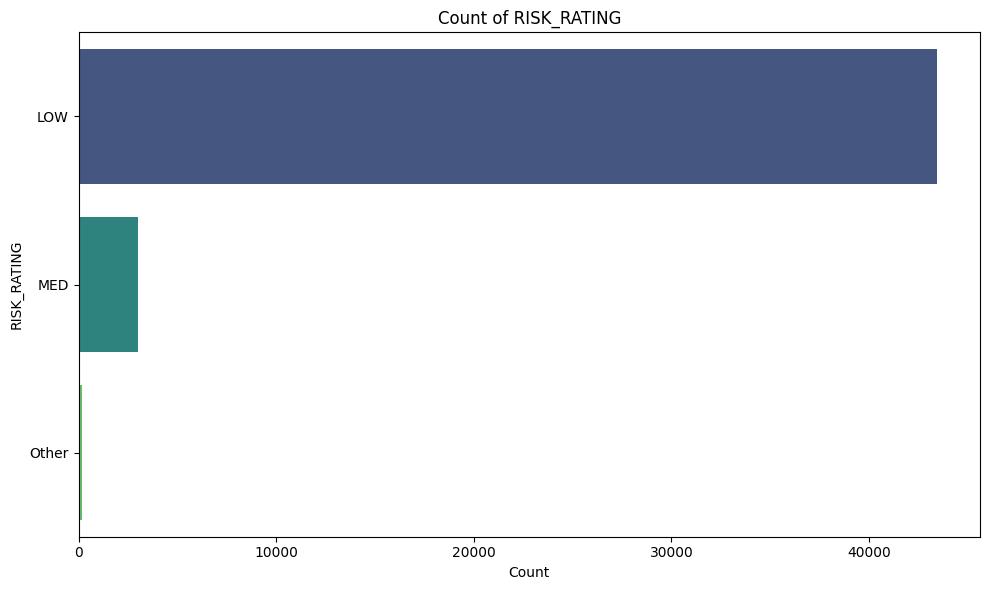


--- DORMANT_STATUS ---


,proportion
DORMANT_STATUS,
A,0.689990
D,0.309903
Other,0.000107


/tmp/ipython-input-1046606977.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10], palette='viridis')


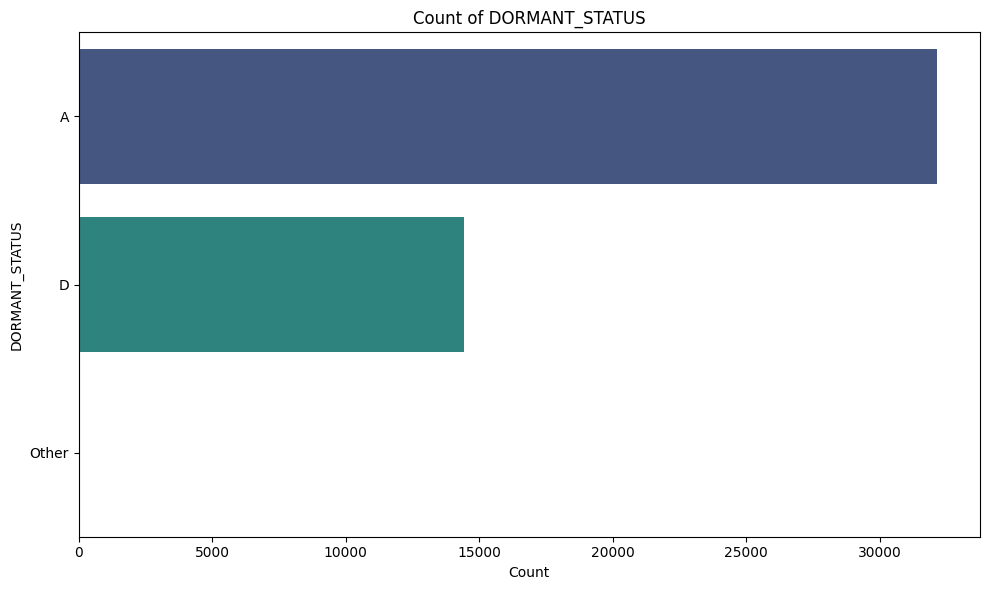

In [ ]:
print("Value Counts for Categorical Features:")
for col in categorical_cols:
    print(f"\n--- {col} ---")
    display(df[col].value_counts(normalize=True))

    # Plot bar plots for categorical features (top 10 if many unique values)
    plt.figure(figsize=(10, 6))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10], palette='viridis')
    plt.title(f'Count of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

## Multivariate Analysis

### Multivariate Analysis: Numerical Features


Correlation Matrix (first 5x5 values):
                     INTTRATE  MONTHLY_AVG_DEP    FD_AMT  MONTHLY_AVG_CR_AMT  \
INTTRATE            1.000000         0.054970  0.021480            0.007369   
MONTHLY_AVG_DEP     0.054970         1.000000  0.140432            0.145647   
FD_AMT              0.021480         0.140432  1.000000            0.069217   
MONTHLY_AVG_CR_AMT  0.007369         0.145647  0.069217            1.000000   
MONTHLY_AVG_DR_AMT  0.008150         0.184130  0.203941            0.466152   

                    MONTHLY_AVG_DR_AMT  
INTTRATE                      0.008150  
MONTHLY_AVG_DEP               0.184130  
FD_AMT                        0.203941  
MONTHLY_AVG_CR_AMT            0.466152  
MONTHLY_AVG_DR_AMT            1.000000  


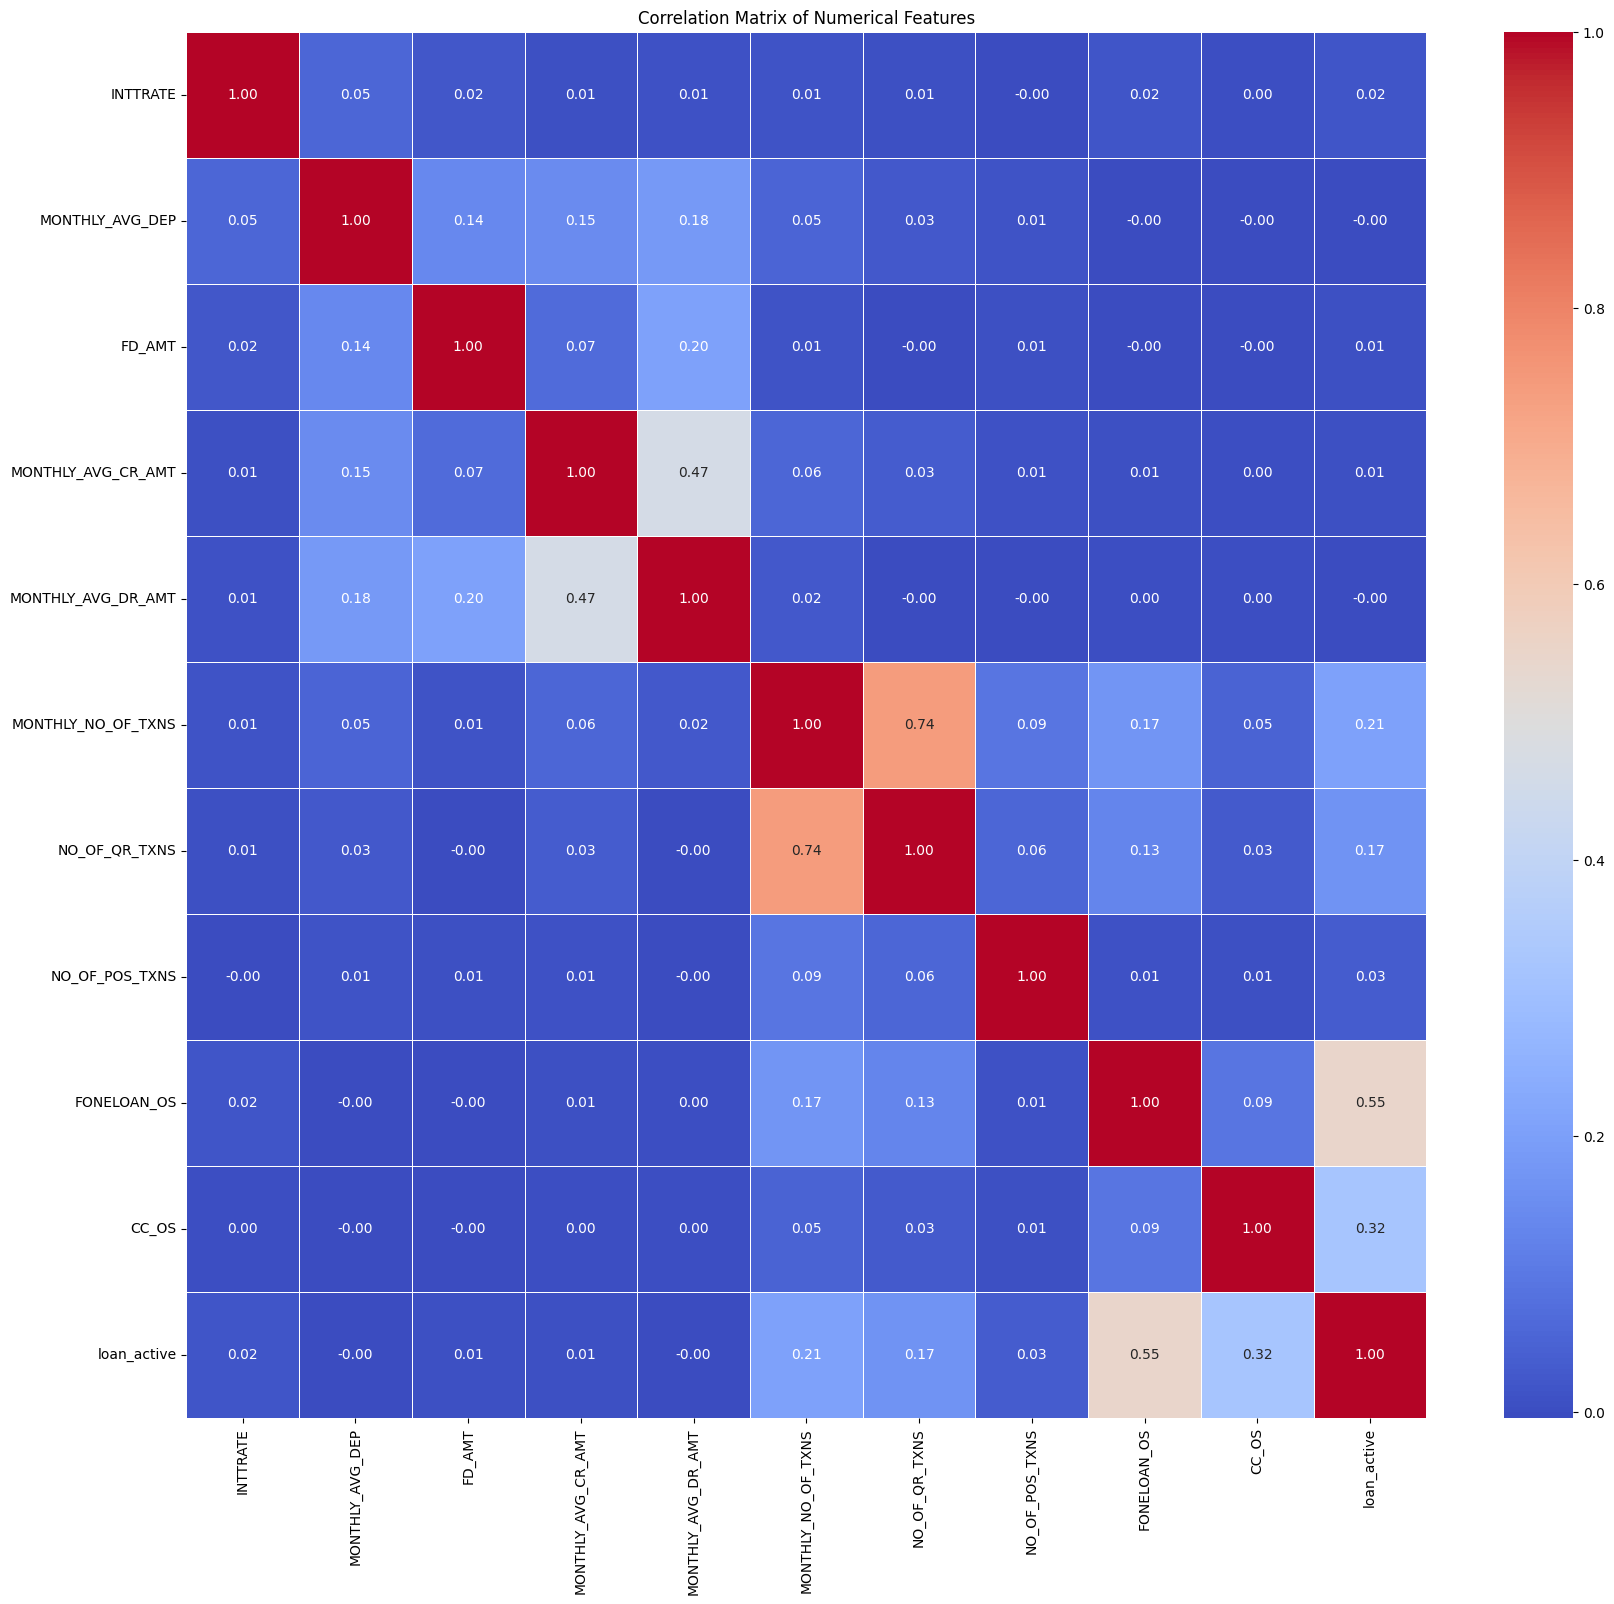

In [ ]:
corr_matrix = df[numeric_cols].corr()
print("\nCorrelation Matrix (first 5x5 values):\n", corr_matrix.iloc[:5, :5])
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Multivariate Analysis: Categorical Features vs. Target Variable ('loan_active')

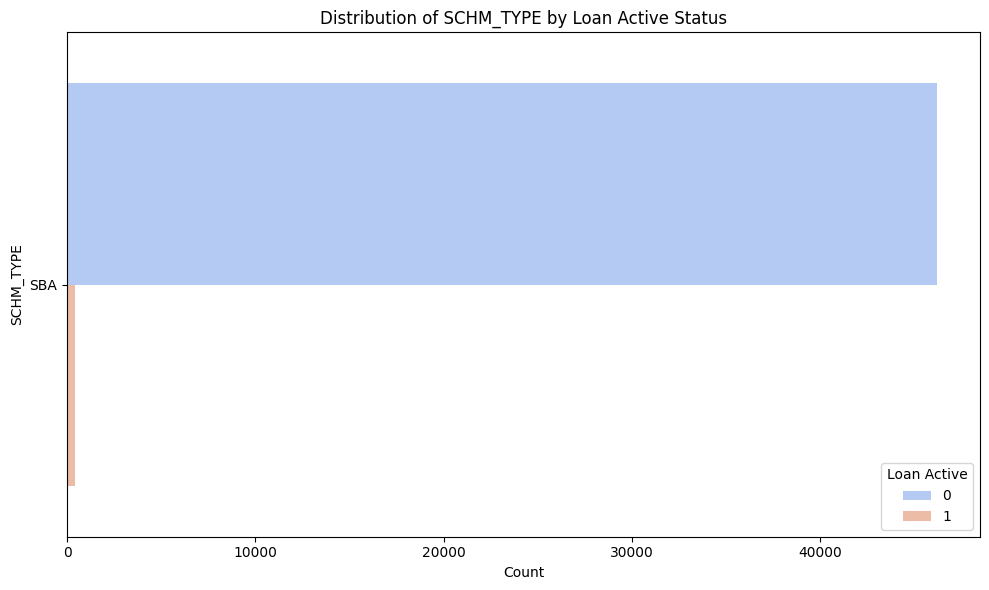

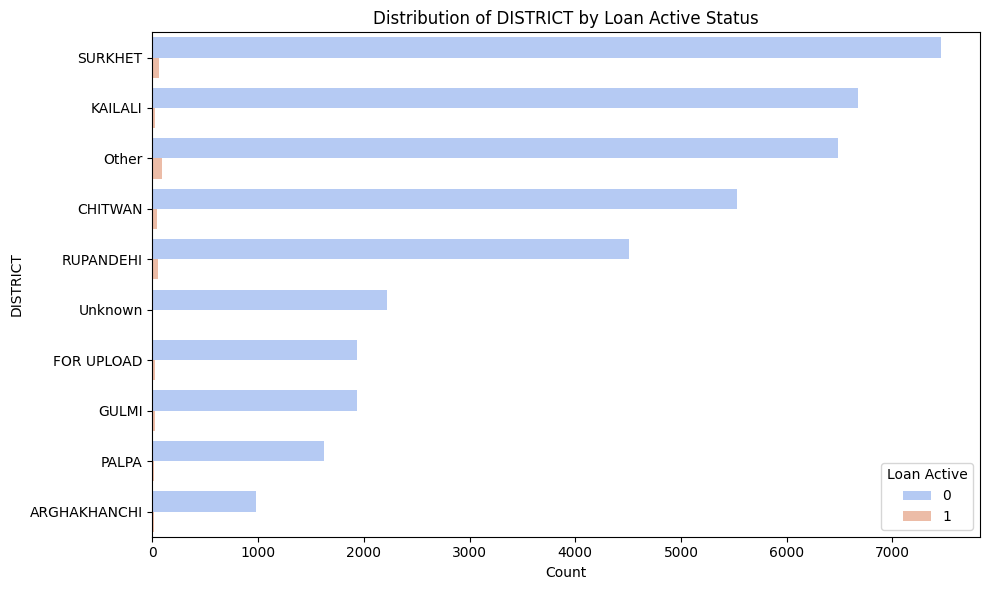

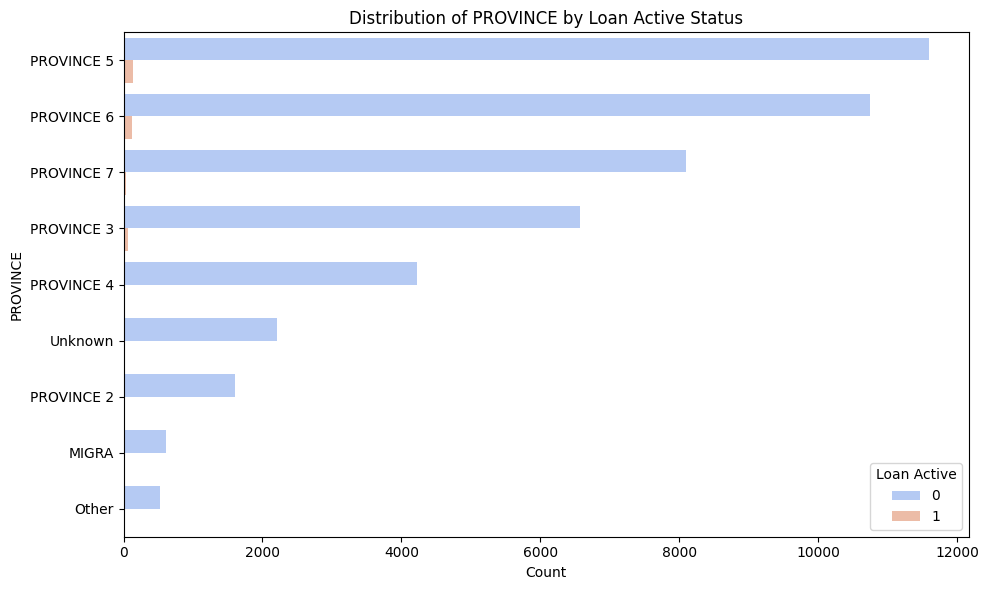

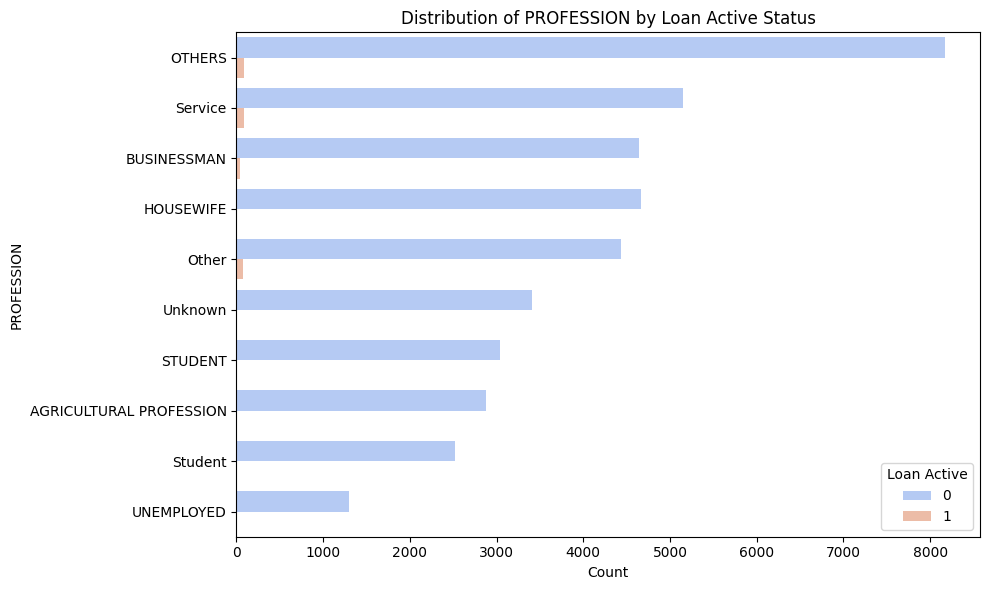

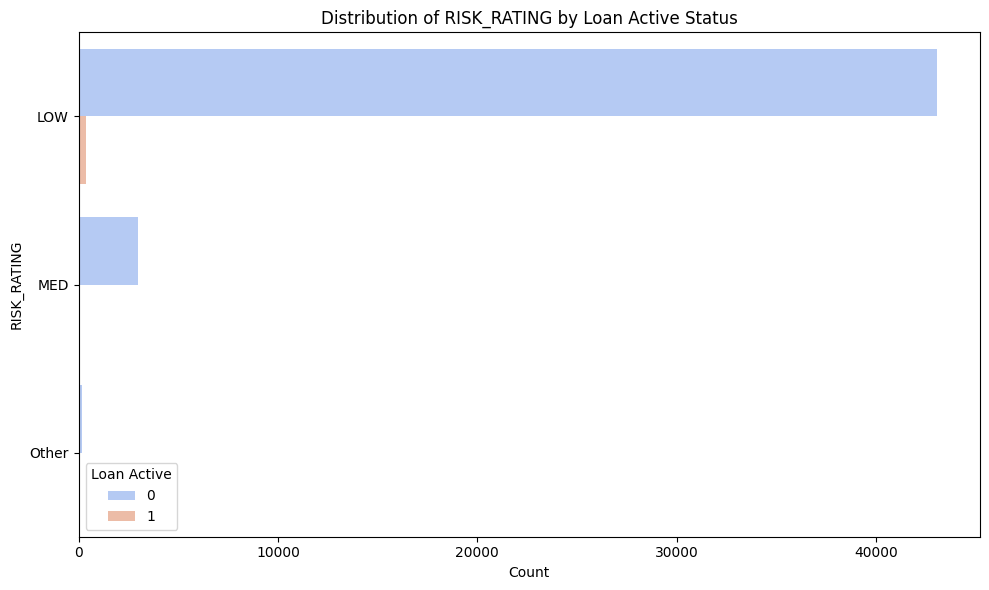

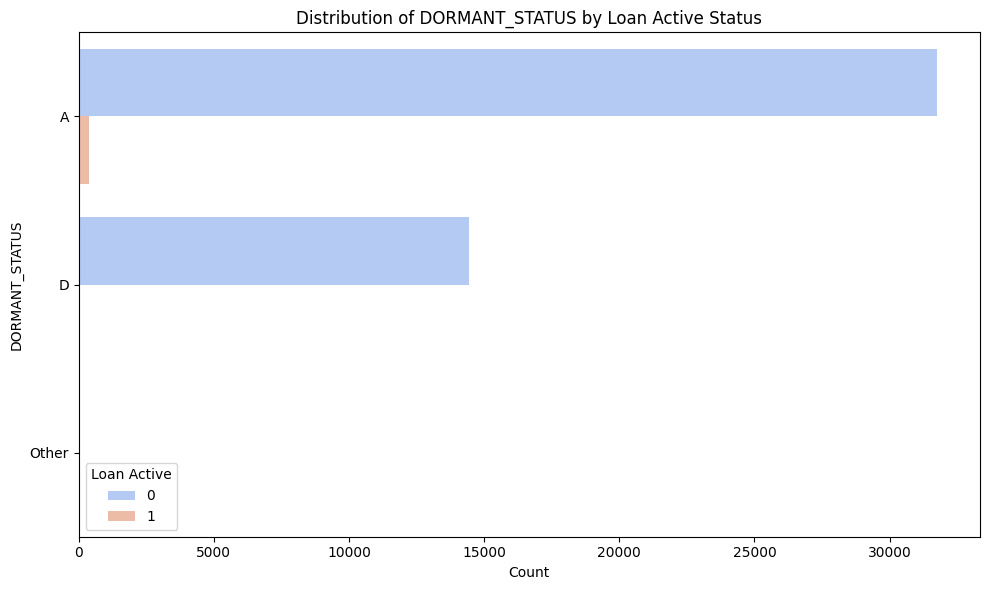

In [ ]:
for col in categorical_cols:
    if col != 'loan_active': # Exclude the target itself if it was mistakenly included
        plt.figure(figsize=(10, 6))
        sns.countplot(y=col, hue='loan_active', data=df, order=df[col].value_counts().index[:10], palette='coolwarm')
        plt.title(f'Distribution of {col} by Loan Active Status')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.legend(title='Loan Active')
        plt.tight_layout()
        plt.show()

In [ ]:
# Saving the processed data
output_file_path = "/content/drive/MyDrive/Tangible/DataSet17Dec2025_processed.xlsx"

# Save the DataFrame to an Excel file
df.to_excel(output_file_path, index=False)

print(f"Processed DataFrame saved to: {output_file_path}")

Processed DataFrame saved to: /content/drive/MyDrive/Tangible/DataSet17Dec2025_processed.xlsx


In [ ]:
input_file_path = "/content/drive/MyDrive/Tangible/DataSet17Dec2025_processed.xlsx"
df = pd.read_excel(input_file_path)

In [ ]:
print(df.shape)
print(df.columns)

(46592, 22)
Index(['ACCT_OPN_DATE', 'SCHM_TYPE', 'INTTRATE', 'CUST_DOB', 'MONTHLY_AVG_DEP',
       'FD_AMT', 'MONTHLY_AVG_CR_AMT', 'MONTHLY_AVG_DR_AMT',
       'MONTHLY_NO_OF_TXNS', 'DISTRICT', 'PROVINCE', 'PROFESSION',
       'RISK_RATING', 'DORMANT_STATUS', 'NO_OF_QR_TXNS', 'NO_OF_POS_TXNS',
       'FONELOAN_OS', 'CC_OS', 'MAPPED_FORACID', 'MAPPED_CIF_ID', 'AS_ON',
       'loan_active'],
      dtype='object')


In [ ]:
y = df['loan_active']
# removing y variable (loan active), date-time variables and account number related variables (We can use data-time variables as well, it is not necessary to remove them)
X = df.drop(columns=['loan_active', 'MAPPED_FORACID', 'MAPPED_CIF_ID', 'ACCT_OPN_DATE', 'CUST_DOB', 'AS_ON'])

### Train-Test Split

Split the dataset into training and testing sets (e.g., 80/20 ratio), ensuring stratification on the `y` variable to maintain class distribution in both sets.


In [ ]:
from sklearn.model_selection import train_test_split
print("y", y.sum())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_train shape: {y_train.sum()}")
print(f"y_test shape: {y_test.sum()}")

y 395
X_train shape: (37273, 16)
X_test shape: (9319, 16)
y_train shape: (37273,)
y_test shape: (9319,)
y_train shape: 316
y_test shape: 79


In [ ]:
X_train.columns

Index(['SCHM_TYPE', 'INTTRATE', 'MONTHLY_AVG_DEP', 'FD_AMT',
       'MONTHLY_AVG_CR_AMT', 'MONTHLY_AVG_DR_AMT', 'MONTHLY_NO_OF_TXNS',
       'DISTRICT', 'PROVINCE', 'PROFESSION', 'RISK_RATING', 'DORMANT_STATUS',
       'NO_OF_QR_TXNS', 'NO_OF_POS_TXNS', 'FONELOAN_OS', 'CC_OS'],
      dtype='object')

## Initial Preprocessing for Model

### Subtask:
Apply one-hot encoding to all categorical features and standard scaling to all numerical features within the X variables. Use `ColumnTransformer` for robust preprocessing, fitting on the training data and transforming both training and testing data.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify numerical and categorical column names
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include='object').columns

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep other columns (if any) as they are
)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform both training and testing sets
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Shape of X_train_processed:", X_train_processed.shape)
print("Shape of X_test_processed:", X_test_processed.shape)

Shape of X_train_processed: (37273, 63)
Shape of X_test_processed: (9319, 63)


In [ ]:
# To view the names of the features:
feature_names = preprocessor.get_feature_names_out()
print(feature_names)

['num__INTTRATE' 'num__MONTHLY_AVG_DEP' 'num__FD_AMT'
 'num__MONTHLY_AVG_CR_AMT' 'num__MONTHLY_AVG_DR_AMT'
 'num__MONTHLY_NO_OF_TXNS' 'num__NO_OF_QR_TXNS' 'num__NO_OF_POS_TXNS'
 'num__FONELOAN_OS' 'num__CC_OS' 'cat__SCHM_TYPE_SBA'
 'cat__DISTRICT_ACHHAM' 'cat__DISTRICT_ARGHAKHANCHI'
 'cat__DISTRICT_BAGLUNG' 'cat__DISTRICT_BARDIYA' 'cat__DISTRICT_CHITWAN'
 'cat__DISTRICT_FOR UPLOAD' 'cat__DISTRICT_GORKHA' 'cat__DISTRICT_GULMI'
 'cat__DISTRICT_KAILALI' 'cat__DISTRICT_KAPILVASTU' 'cat__DISTRICT_MIGRA'
 'cat__DISTRICT_NAWALPARASI' 'cat__DISTRICT_Other' 'cat__DISTRICT_PALPA'
 'cat__DISTRICT_PARSA' 'cat__DISTRICT_RUPANDEHI' 'cat__DISTRICT_SURKHET'
 'cat__DISTRICT_SYANGJA' 'cat__DISTRICT_TANAHU' 'cat__DISTRICT_Unknown'
 'cat__PROVINCE_MIGRA' 'cat__PROVINCE_Other' 'cat__PROVINCE_PROVINCE 2'
 'cat__PROVINCE_PROVINCE 3' 'cat__PROVINCE_PROVINCE 4'
 'cat__PROVINCE_PROVINCE 5' 'cat__PROVINCE_PROVINCE 6'
 'cat__PROVINCE_PROVINCE 7' 'cat__PROVINCE_Unknown'
 'cat__PROFESSION_AGRICULTURAL PROFESSION'
 

## Train Initial Logistic Regression Model

Train a logistic regression model using the preprocessed training data.


In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Using solver='liblinear' or 'saga' for better convergence with scaled data, and increasing max_iter
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Fit the model to the preprocessed training data
model.fit(X_train_processed, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


In [ ]:
print("Intercept (Bias):", model.intercept_)
print("Coefficients:", model.coef_)
feature_names = preprocessor.get_feature_names_out()
coeffs_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': model.coef_[0]})
coeffs_df = coeffs_df.sort_values(by='Coefficient', key=abs, ascending=False)

print(coeffs_df)

Intercept (Bias): [-2.3287581]
Coefficients: [[ 5.06151388e-02 -7.74691249e-01 -3.53009917e-02 -7.01976907e-02
  -3.95998352e-01  2.81175304e-02  8.46123934e-02 -7.89768098e-02
   6.94650657e+00  7.09279987e+00 -2.32875810e+00 -2.92407204e-01
   2.29904265e-01 -2.46543332e-01 -6.42929449e-02 -2.56222460e-01
   6.45110749e-01 -2.64873798e-01  4.59462369e-01  9.53784818e-02
  -3.41565805e-01 -1.56174595e-01  1.29146058e-01 -1.11440579e-01
   2.06205196e-02 -3.11006094e-01 -8.01743090e-02 -1.13834918e+00
  -2.90113155e-02 -2.49420485e-01 -3.66898438e-01 -1.58831781e-01
  -3.50382986e-01 -7.08085144e-01  3.65219456e-01 -5.42096071e-01
   1.46155009e-01 -2.15558896e-01 -5.03897766e-01 -3.61279919e-01
  -7.98590898e-01 -3.73248846e-01  5.32939101e-01  8.57229250e-01
  -3.66703780e-01 -9.94375105e-01 -9.54704372e-02 -2.67851159e-01
   4.74629693e-03  7.08820516e-01  5.33814854e-01 -6.37587336e-01
   3.01967449e-01 -7.68428290e-01 -4.28229474e-01 -4.05468422e-01
  -1.32321815e-01 -1.31196320e+


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9240
           1       1.00      0.82      0.90        79

    accuracy                           1.00      9319
   macro avg       1.00      0.91      0.95      9319
weighted avg       1.00      1.00      1.00      9319


Confusion Matrix:
[[9240    0]
 [  14   65]]


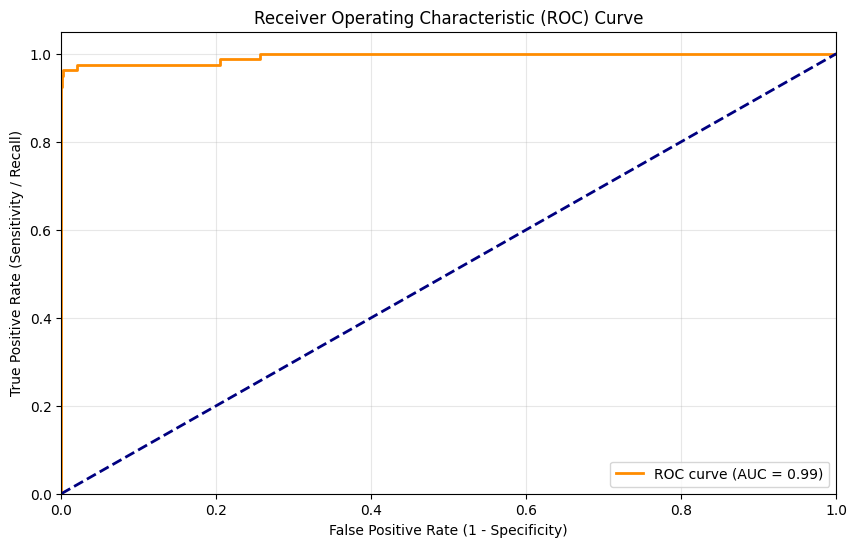


ROC AUC Score: 0.9939
EVALUATING DIFFERENT THRESHOLDS

--- THRESHOLD: 0.2 ---
Confusion Matrix:
[[9240    0]
 [  12   67]]
True Negatives (No loan to non-loan customer): 9240
False Positives (Loan to non-loan customer):      0
False Negatives (No loan to loan customer):      12
True Positives (Loan to loan customer):           67

Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9240
           1       1.00      0.85      0.92        79

    accuracy                           1.00      9319
   macro avg       1.00      0.92      0.96      9319
weighted avg       1.00      1.00      1.00      9319

------------------------------

--- THRESHOLD: 0.5 ---
Confusion Matrix:
[[9240    0]
 [  14   65]]
True Negatives (No loan to non-loan customer): 9240
False Positives (Loan to non-loan customer):      0
False Negatives (No loan to loan customer):      14
True Positives (Loan to loan customer):           65

Report:
             

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Make predictions on the preprocessed test data
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1] # Probability of the positive class (class 1)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


print(f"\nROC AUC Score: {roc_auc:.4f}")

thresholds = [0.2, 0.5, 0.8]
print(f"{'='*60}")
print(f"EVALUATING DIFFERENT THRESHOLDS")
print(f"{'='*60}")

for thresh in thresholds:
    # 3. Create custom predictions based on the current threshold
    # If probability >= threshold, Class is 1. Otherwise, 0.
    y_custom_pred = (y_pred_proba >= thresh).astype(int)

    print(f"\n--- THRESHOLD: {thresh} ---")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_custom_pred)
    tn, fp, fn, tp = cm.ravel()

    print("Confusion Matrix:")
    print(cm)
    print(f"True Negatives (No loan to non-loan customer): {tn}")
    print(f"False Positives (Loan to non-loan customer):      {fp}")
    print(f"False Negatives (No loan to loan customer):      {fn}")
    print(f"True Positives (Loan to loan customer):           {tp}")

    # Classification Report
    print("\nReport:")
    print(classification_report(y_test, y_custom_pred))
    print("-" * 30)


Our model is working really well, as visible from the ROC curve. However, this is not because we have created a very good model. But due to data leakage. We need to remvoe the variables 'FONELOAN_OS' and 'CC_OS' to avoid the data leakage. It, is visible from the weights of the model as well. The weights for features CC_OS and FONELOAN_OS are much more higher then other features. This means that the model is heavily relying on these feaatures.

In [ ]:
file_path = "/content/drive/MyDrive/Tangible/DataSet17Dec2025_processed.xlsx"
df  = pd.read_excel(file_path)

print(f"Processed DataFrame saved to: {file_path}")

y = df['loan_active']
# Removing 'FONELOAN_OS' and 'CC_OS'
# NOTE: Based on your domain knowledge you could remove other fields as well.
X = df.drop(columns=['loan_active','FONELOAN_OS', 'CC_OS', 'MAPPED_FORACID', 'MAPPED_CIF_ID', 'ACCT_OPN_DATE', 'CUST_DOB', 'AS_ON'])


Processed DataFrame saved to: /content/drive/MyDrive/Tangible/DataSet17Dec2025_processed.xlsx


In [ ]:
from sklearn.model_selection import train_test_split
print("y", y.sum())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_train shape: {y_train.sum()}")
print(f"y_test shape: {y_test.sum()}")

y 395
X_train shape: (37273, 14)
X_test shape: (9319, 14)
y_train shape: (37273,)
y_test shape: (9319,)
y_train shape: 316
y_test shape: 79


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify numerical and categorical column names
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include='object').columns

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep other columns (if any) as they are
)

# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform both training and testing sets
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Shape of X_train_processed:", X_train_processed.shape)
print("Shape of X_test_processed:", X_test_processed.shape)

Shape of X_train_processed: (37273, 61)
Shape of X_test_processed: (9319, 61)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Fit the model to the preprocessed training data
model.fit(X_train_processed, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.



Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9240
           1       0.38      0.04      0.07        79

    accuracy                           0.99      9319
   macro avg       0.68      0.52      0.53      9319
weighted avg       0.99      0.99      0.99      9319


Confusion Matrix:
[[9235    5]
 [  76    3]]


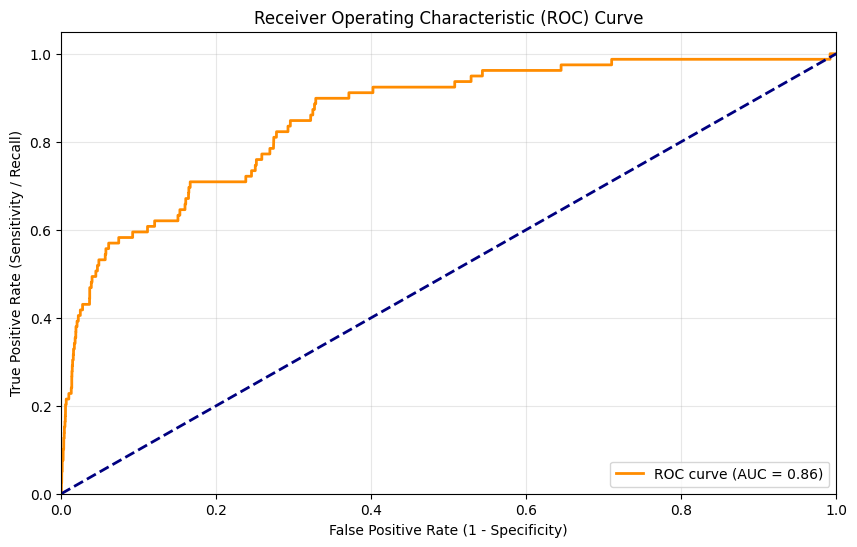


ROC AUC Score: 0.8571
EVALUATING DIFFERENT THRESHOLDS

--- THRESHOLD: 0.2 ---
Confusion Matrix:
[[9216   24]
 [  71    8]]
True Negatives (No loan to non-loan customer): 9216
False Positives (Loan to non-loan customer):      24
False Negatives (No loan to loan custmer):      71
True Positives (Loan to loan customer):           8

Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9240
           1       0.25      0.10      0.14        79

    accuracy                           0.99      9319
   macro avg       0.62      0.55      0.57      9319
weighted avg       0.99      0.99      0.99      9319

------------------------------

--- THRESHOLD: 0.5 ---
Confusion Matrix:
[[9235    5]
 [  76    3]]
True Negatives (No loan to non-loan customer): 9235
False Positives (Loan to non-loan customer):      5
False Negatives (No loan to loan custmer):      76
True Positives (Loan to loan customer):           3

Report:
              pr

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Make predictions on the preprocessed test data
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1] # Probability of the positive class (class 1)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


print(f"\nROC AUC Score: {roc_auc:.4f}")

thresholds = [0.2, 0.5, 0.8]
print(f"{'='*60}")
print(f"EVALUATING DIFFERENT THRESHOLDS")
print(f"{'='*60}")

for thresh in thresholds:
    # 3. Create custom predictions based on the current threshold
    # If probability >= threshold, Class is 1. Otherwise, 0.
    y_custom_pred = (y_pred_proba >= thresh).astype(int)

    print(f"\n--- THRESHOLD: {thresh} ---")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_custom_pred)
    tn, fp, fn, tp = cm.ravel()

    print("Confusion Matrix:")
    print(cm)
    print(f"True Negatives (No loan to non-loan customer): {tn}")
    print(f"False Positives (Loan to non-loan customer):      {fp}")
    print(f"False Negatives (No loan to loan custmer):      {fn}")
    print(f"True Positives (Loan to loan customer):           {tp}")

    # Classification Report
    print("\nReport:")
    print(classification_report(y_test, y_custom_pred))
    print("-" * 30)


### The following are some methods(not all) to handle class imbalances

In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Using solver='liblinear' or 'saga' for better convergence with scaled data, and increasing max_iter
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, class_weight='balanced')

# Fit the model to the preprocessed training data
model.fit(X_train_processed, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      9240
           1       0.04      0.80      0.07        79

    accuracy                           0.83      9319
   macro avg       0.52      0.81      0.49      9319
weighted avg       0.99      0.83      0.90      9319


Confusion Matrix:
[[7649 1591]
 [  16   63]]


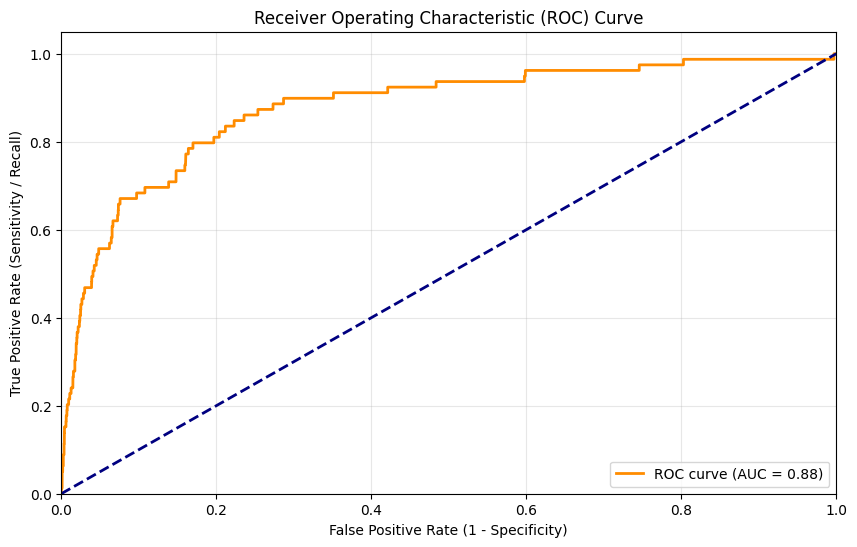


ROC AUC Score: 0.8768
EVALUATING DIFFERENT THRESHOLDS

--- THRESHOLD: 0.2 ---
Confusion Matrix:
[[5589 3651]
 [   7   72]]
True Negatives (Correct Rejection): 5589
False Positives (False Alarm):      3651
False Negatives (Missed Oppt):      7
True Positives (Success):           72

Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75      9240
           1       0.02      0.91      0.04        79

    accuracy                           0.61      9319
   macro avg       0.51      0.76      0.40      9319
weighted avg       0.99      0.61      0.75      9319

------------------------------

--- THRESHOLD: 0.5 ---
Confusion Matrix:
[[7649 1591]
 [  16   63]]
True Negatives (Correct Rejection): 7649
False Positives (False Alarm):      1591
False Negatives (Missed Oppt):      16
True Positives (Success):           63

Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      9240
   

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Make predictions on the preprocessed test data
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1] # Probability of the positive class (class 1)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


print(f"\nROC AUC Score: {roc_auc:.4f}")

thresholds = [0.2, 0.5, 0.8]
print(f"{'='*60}")
print(f"EVALUATING DIFFERENT THRESHOLDS")
print(f"{'='*60}")

for thresh in thresholds:
    # 3. Create custom predictions based on the current threshold
    # If probability >= threshold, Class is 1. Otherwise, 0.
    y_custom_pred = (y_pred_proba >= thresh).astype(int)

    print(f"\n--- THRESHOLD: {thresh} ---")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_custom_pred)
    tn, fp, fn, tp = cm.ravel()

    print("Confusion Matrix:")
    print(cm)
    print(f"True Negatives (Correct Rejection): {tn}")
    print(f"False Positives (False Alarm):      {fp}")
    print(f"False Negatives (Missed Oppt):      {fn}")
    print(f"True Positives (Success):           {tp}")

    # Classification Report
    print("\nReport:")
    print(classification_report(y_test, y_custom_pred))
    print("-" * 30)


### Apply SMOTE Oversampling

Apply Synthetic Minority Over-sampling Technique (SMOTE) to the training data (`X_train_processed`, `y_train`) to increase the number of instances in the minority class. This will create a more balanced dataset for training.


In [ ]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(f"Original training data shape (X): {X_train_processed.shape}, (y): {y_train.shape}")
print(f"Resampled training data shape (X): {X_train_smote.shape}, (y): {y_train_smote.shape}")
print(f"Class distribution in y_train_smote:\n{pd.Series(y_train_smote).value_counts()}")

Original training data shape (X): (37273, 61), (y): (37273,)
Resampled training data shape (X): (73914, 61), (y): (73914,)
Class distribution in y_train_smote:
loan_active
0    36957
1    36957
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression


model_smote = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Fit the model to the SMOTE-oversampled training data
model_smote.fit(X_train_smote, y_train_smote)

print("Logistic Regression model trained successfully on SMOTE-oversampled data.")

Logistic Regression model trained successfully on SMOTE-oversampled data.



Classification Report (SMOTE model):
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      9240
           1       0.04      0.75      0.07        79

    accuracy                           0.83      9319
   macro avg       0.52      0.79      0.49      9319
weighted avg       0.99      0.83      0.90      9319


Confusion Matrix (SMOTE model):
[[7686 1554]
 [  20   59]]


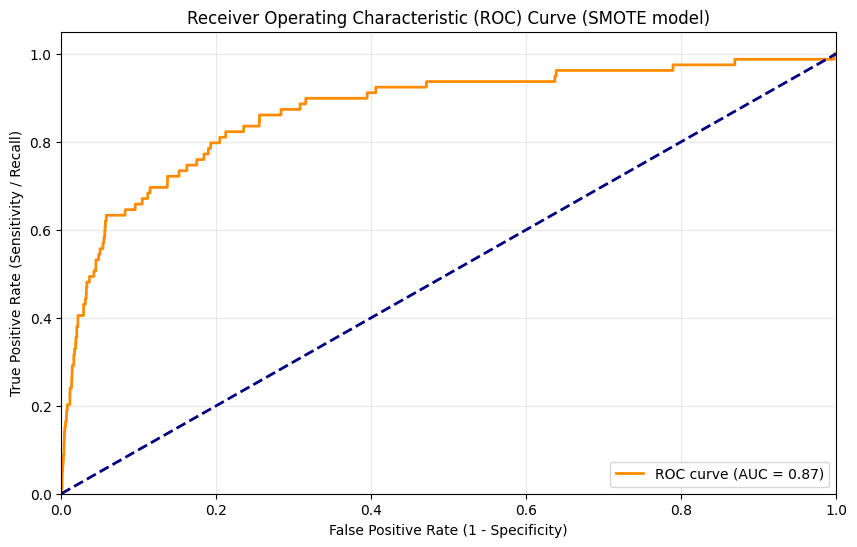


ROC AUC Score (SMOTE model): 0.8707

EVALUATING DIFFERENT THRESHOLDS FOR SMOTE MODEL

--- THRESHOLD: 0.2 ---
Confusion Matrix:
[[5926 3314]
 [   8   71]]
True Negatives (Correct Rejection): 5926
False Positives (False Alarm):      3314
False Negatives (Missed Oppt):      8
True Positives (Success):           71

Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78      9240
           1       0.02      0.90      0.04        79

    accuracy                           0.64      9319
   macro avg       0.51      0.77      0.41      9319
weighted avg       0.99      0.64      0.77      9319

------------------------------

--- THRESHOLD: 0.5 ---
Confusion Matrix:
[[7686 1554]
 [  20   59]]
True Negatives (Correct Rejection): 7686
False Positives (False Alarm):      1554
False Negatives (Missed Oppt):      20
True Positives (Success):           59

Report:
              precision    recall  f1-score   support

           0       1.00   

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the preprocessed test data using the SMOTE-trained model
y_pred_smote = model_smote.predict(X_test_processed)
y_pred_proba_smote = model_smote.predict_proba(X_test_processed)[:, 1] # Probability of the positive class (class 1)

# Print Classification Report
print("\nClassification Report (SMOTE model):")
print(classification_report(y_test, y_pred_smote))

# Print Confusion Matrix
print("\nConfusion Matrix (SMOTE model):")
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
print(conf_matrix_smote)

# Calculate ROC curve and AUC
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, y_pred_proba_smote)
roc_auc_smote = auc(fpr_smote, tpr_smote)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_smote, tpr_smote, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_smote:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve (SMOTE model)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nROC AUC Score (SMOTE model): {roc_auc_smote:.4f}")

# Evaluate at different thresholds for comparison
thresholds = [0.2, 0.5, 0.8]
print(f"\n{'='*60}")
print(f"EVALUATING DIFFERENT THRESHOLDS FOR SMOTE MODEL")
print(f"{'='*60}")

for thresh in thresholds:
    y_custom_pred_smote = (y_pred_proba_smote >= thresh).astype(int)

    print(f"\n--- THRESHOLD: {thresh} ---")

    cm_smote = confusion_matrix(y_test, y_custom_pred_smote)
    tn, fp, fn, tp = cm_smote.ravel()

    print("Confusion Matrix:")
    print(cm_smote)
    print(f"True Negatives (Correct Rejection): {tn}")
    print(f"False Positives (False Alarm):      {fp}")
    print(f"False Negatives (Missed Oppt):      {fn}")
    print(f"True Positives (Success):           {tp}")

    print("\nReport:")
    print(classification_report(y_test, y_custom_pred_smote))
    print("-" * 30)

### Apply Random Under Sampling


Apply Random Under Sampling to the training data (`X_train_processed`, `y_train`) to reduce the number of instances in the majority class. This will create a more balanced dataset for training.

#### Instructions:
1. Import the `RandomUnderSampler` class from `imblearn.under_sampling`.
2. Instantiate `RandomUnderSampler` (you can use `random_state=42` for reproducibility).
3. Apply Random Under Sampling to `X_train_processed` and `y_train` using the `.fit_resample()` method to generate `X_train_rus` and `y_train_rus`.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply Random Under Sampling to the training data
X_train_rus, y_train_rus = rus.fit_resample(X_train_processed, y_train)

print(f"Original training data shape (X): {X_train_processed.shape}, (y): {y_train.shape}")
print(f"Resampled training data shape (X): {X_train_rus.shape}, (y): {y_train_rus.shape}")
print(f"Class distribution in y_train_rus:\n{pd.Series(y_train_rus).value_counts()}")

Original training data shape (X): (37273, 61), (y): (37273,)
Resampled training data shape (X): (632, 61), (y): (632,)
Class distribution in y_train_rus:
loan_active
0    316
1    316
Name: count, dtype: int64


In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Setting solver='liblinear' and increasing max_iter for convergence.
model_rus = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Fit the model to the Random Under Sampled training data
model_rus.fit(X_train_rus, y_train_rus)

print("Logistic Regression model trained successfully on Random Under Sampled data.")

Logistic Regression model trained successfully on Random Under Sampled data.



Classification Report (RUS model):
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9240
           1       0.04      0.81      0.08        79

    accuracy                           0.84      9319
   macro avg       0.52      0.83      0.50      9319
weighted avg       0.99      0.84      0.91      9319


Confusion Matrix (RUS model):
[[7770 1470]
 [  15   64]]


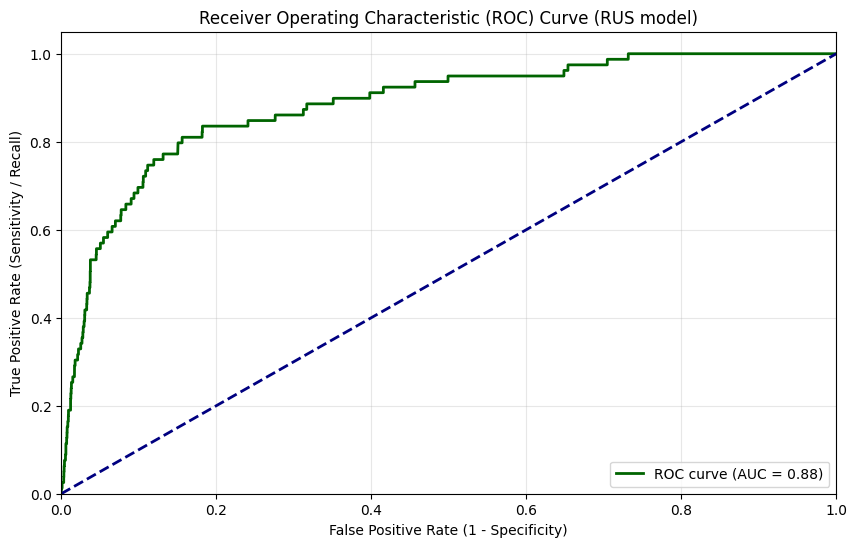


ROC AUC Score (RUS model): 0.8836

EVALUATING DIFFERENT THRESHOLDS FOR RUS MODEL

--- THRESHOLD: 0.2 ---
Confusion Matrix:
[[5250 3990]
 [   6   73]]
True Negatives (Correct Rejection): 5250
False Positives (False Alarm):      3990
False Negatives (Missed Oppt):      6
True Positives (Success):           73

Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.72      9240
           1       0.02      0.92      0.04        79

    accuracy                           0.57      9319
   macro avg       0.51      0.75      0.38      9319
weighted avg       0.99      0.57      0.72      9319

------------------------------

--- THRESHOLD: 0.5 ---
Confusion Matrix:
[[7770 1470]
 [  15   64]]
True Negatives (Correct Rejection): 7770
False Positives (False Alarm):      1470
False Negatives (Missed Oppt):      15
True Positives (Success):           64

Report:
              precision    recall  f1-score   support

           0       1.00      0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Make predictions on the preprocessed test data using the RUS-trained model
y_pred_rus = model_rus.predict(X_test_processed)
y_pred_proba_rus = model_rus.predict_proba(X_test_processed)[:, 1] # Probability of the positive class (class 1)

# Print Classification Report
print("\nClassification Report (RUS model):")
print(classification_report(y_test, y_pred_rus))

# Print Confusion Matrix
print("\nConfusion Matrix (RUS model):")
conf_matrix_rus = confusion_matrix(y_test, y_pred_rus)
print(conf_matrix_rus)

# Calculate ROC curve and AUC
fpr_rus, tpr_rus, thresholds_rus = roc_curve(y_test, y_pred_proba_rus)
roc_auc_rus = auc(fpr_rus, tpr_rus)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rus, tpr_rus, color='darkgreen', lw=2, label=f'ROC curve (AUC = {roc_auc_rus:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve (RUS model)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nROC AUC Score (RUS model): {roc_auc_rus:.4f}")

# Evaluate at different thresholds for comparison
thresholds = [0.2, 0.5, 0.8]
print(f"\n{'='*60}")
print(f"EVALUATING DIFFERENT THRESHOLDS FOR RUS MODEL")
print(f"{'='*60}")

for thresh in thresholds:
    y_custom_pred_rus = (y_pred_proba_rus >= thresh).astype(int)

    print(f"\n--- THRESHOLD: {thresh} ---")

    cm_rus = confusion_matrix(y_test, y_custom_pred_rus)
    tn, fp, fn, tp = cm_rus.ravel()

    print("Confusion Matrix:")
    print(cm_rus)
    print(f"True Negatives (Correct Rejection): {tn}")
    print(f"False Positives (False Alarm):      {fp}")
    print(f"False Negatives (Missed Oppt):      {fn}")
    print(f"True Positives (Success):           {tp}")

    print("\nReport:")
    print(classification_report(y_test, y_custom_pred_rus))
    print("-" * 30)

In [ ]:
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

# Extracting Recall and ROC AUC for each model
# Baseline with class_weight='balanced'
# Note: model and y_test values from the previous 'class_weight balanced' run
report_balanced = classification_report(y_test, model.predict(X_test_processed), output_dict=True)
recall_balanced = report_balanced['1']['recall']
roc_auc_balanced = roc_auc

# SMOTE model
report_smote = classification_report(y_test, y_pred_smote, output_dict=True)
recall_smote = report_smote['1']['recall']
roc_auc_smote_val = roc_auc_smote

# RUS model
report_rus = classification_report(y_test, y_pred_rus, output_dict=True)
recall_rus = report_rus['1']['recall']
roc_auc_rus_val = roc_auc_rus

# Print comparison table
print(f"{'Model':<30} | {'Minority Class Recall':<25} | {'ROC AUC Score':<20}")
print(f"{'='*30} | {'='*25} | {'='*20}")
print(f"{'Baseline (class_weight)':<30} | {recall_balanced:<25.4f} | {roc_auc_balanced:<20.4f}")
print(f"{'SMOTE Oversampling':<30} | {recall_smote:<25.4f} | {roc_auc_smote_val:<20.4f}")
print(f"{'RUS Under Sampling':<30} | {recall_rus:<25.4f} | {roc_auc_rus_val:<20.4f}")
print("="*60)

print("\nSummary: Choose the model that best balances minority class recall and overall AUC based on business requirements.")


MODEL PERFORMANCE COMPARISON
Model                          | Minority Class Recall     | ROC AUC Score       
============================== | ========================= | ====================
Baseline (class_weight)        | 0.7975                    | 0.8768              
SMOTE Oversampling             | 0.7468                    | 0.8707              
RUS Under Sampling             | 0.8101                    | 0.8836              

Summary: Choose the model that best balances minority class recall and overall AUC based on business requirements.


## Introduction to Regularization

### L1 (Lasso) Regularization
L1 regularization, also known as Lasso (Least Absolute Shrinkage and Selection Operator), adds a penalty term equal to the absolute value of the magnitude of the coefficients to the loss function. Its primary effect is to shrink some coefficients to zero, effectively performing feature selection. This makes Lasso useful for models with many features, as it helps identify and remove irrelevant ones.

Mathematically, the penalized loss function for linear regression becomes:
$$ \text{Loss}(W) = \text{MSE}(W) + \lambda \sum_{j=1}^{p} |w_j| $$
where $W$ is the vector of coefficients, $\text{MSE}$ is the Mean Squared Error, and $\lambda$ is the regularization strength (hyperparameter).

### L2 (Ridge) Regularization
L2 regularization, or Ridge regression, adds a penalty term equal to the square of the magnitude of the coefficients to the loss function. This penalty shrinks coefficients towards zero (but rarely to exactly zero), reducing their variance and preventing overfitting without performing explicit feature selection.

Mathematically, the penalized loss function for linear regression becomes:
$$ \text{Loss}(W) = \text{MSE}(W) + \lambda \sum_{j=1}^{p} w_j^2 $$
where $W$ is the vector of coefficients, $\text{MSE}$ is the Mean Squared Error, and $\lambda$ is the regularization strength (hyperparameter).

### Role in Managing Bias-Variance Trade-off
Both L1 and L2 regularization address the bias-variance trade-off:

*   **Reducing Variance (Preventing Overfitting):** When a model is too complex and fits the training data too closely, it tends to have high variance, meaning it performs poorly on unseen data. Regularization adds a penalty for large coefficients, which encourages simpler models. By constraining the magnitude of coefficients, regularization prevents the model from assigning too much importance to any single feature or becoming overly sensitive to noise in the training data. This reduces the model's variance and improves its generalization ability.

*   **Impact on Bias:** While regularization primarily reduces variance, it can slightly increase bias. A simpler model might not capture all the nuances in the training data, leading to a small increase in bias. However, in many real-world scenarios, the reduction in variance achieved through regularization far outweighs the slight increase in bias, leading to a better overall model performance.

*   **Lasso's Specific Benefit:** L1 regularization's ability to drive some coefficients to exactly zero means it can produce sparser models. This is beneficial for interpretability and can help in cases where many features are irrelevant, thus implicitly managing complexity and contributing to a better trade-off by reducing the

 NOTE: Even though L1 regularization acts as an automatic feature selection method. It might still be a good idea to perform explicit feature selection steps to reduce the computation burden on the model. (More feautre means we need more compute to train the model.)

 In sklearn the parameter penalty (in earlier versions or 'l1_ratio' in newer versions can be used to implement/modify/remove regularization)